# Exploratory Data Analtsis (EDA): Brazilian Financial Funds
In this section, I'll analyze financial funds market along the years. In this analysis, I'll focus on:

- How are the returns along the years?
- What are the main features of Brazilian funds?
- How did COVID-19 impacted funds market?
- Do higher return funds have something in common?
- Who are the big players? Managers? Issuers? Auditors?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Import funds dataframe
fund_df = pd.read_csv('fund_df.csv')

## Funds features

In [17]:
# How many unique funds in my database
print('Total Funds: ', fund_df['CNPJ_FUNDO'].nunique())
print('\n')
print('Total active funds:', fund_df.groupby(fund_df['SIT_EM FUNCIONAMENTO NORMAL']==1)['CNPJ_FUNDO'].nunique())


Total Funds:  33717


Total active funds: SIT_EM FUNCIONAMENTO NORMAL
False     7758
True     25976
Name: CNPJ_FUNDO, dtype: int64


I have a total of 33,717 unique funds between 2020 and 2024. On which 25,976 active and 7,758 canceled. But this doesn't tell me much, I don't know if canceled funds are concentrated in a specific year. So let's see how funds behave along the years.

In [18]:
# Funds per year
fund_df['year_month'] = pd.to_datetime(fund_df['year_month'])

# Total funds per year
print('Total unique funds per year:',fund_df.groupby(fund_df['year_month'].dt.year)['CNPJ_FUNDO'].nunique())
print('\n')

# Total active funds
print('Total active funds per year:',fund_df.groupby([fund_df['year_month'].dt.year, 
                                                      fund_df['SIT_EM FUNCIONAMENTO NORMAL']==1])['CNPJ_FUNDO'].nunique())

Total unique funds per year: year_month
2020    19838
2021    23650
2022    26084
2023    27484
2024    27656
Name: CNPJ_FUNDO, dtype: int64


Total active funds per year: year_month  SIT_EM FUNCIONAMENTO NORMAL
2020        False                           4661
            True                           15189
2021        False                           5667
            True                           17983
2022        False                           5848
            True                           20237
2023        False                           4876
            True                           22609
2024        False                           3503
            True                           24153
Name: CNPJ_FUNDO, dtype: int64


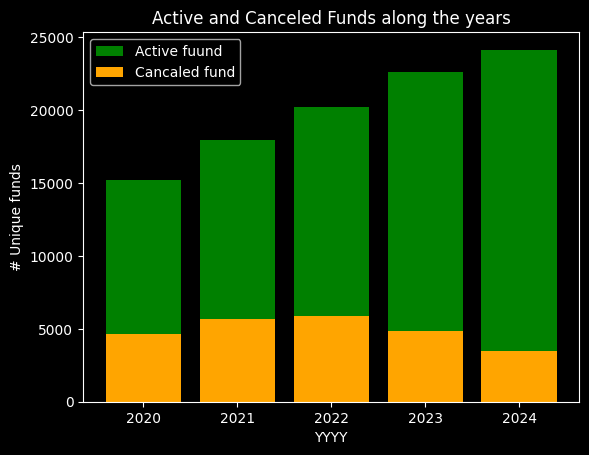

In [31]:
# graph
temp = fund_df.groupby([fund_df['year_month'].dt.year, fund_df['SIT_EM FUNCIONAMENTO NORMAL']==1])['CNPJ_FUNDO'].nunique().reset_index()

plt.bar(temp.loc[temp['SIT_EM FUNCIONAMENTO NORMAL']==1, 'year_month'],
          temp.loc[temp['SIT_EM FUNCIONAMENTO NORMAL']==1,'CNPJ_FUNDO'], color='green', label='Active funds')

plt.bar(temp.loc[temp['SIT_EM FUNCIONAMENTO NORMAL']==0, 'year_month'], 
         temp.loc[temp['SIT_EM FUNCIONAMENTO NORMAL']==0,'CNPJ_FUNDO'], color='orange', label='Canceled funds')

# Add title and label
plt.title('Active and Canceled Funds along the years')
plt.xlabel('YYYY')
plt.ylabel('# Unique funds')

plt.legend()

Based on the graph, I can see the relationship of active and canceled funds is relatively stable along the years. 2024 still a going on so make sense it's a little lower. Interesting to see that even during the pandemic (2020 to 2022), the number of canceled funds didn't increase that much. In fact, the most interesting thing to see is how the number of active funds actually incresed.

This means during the pandemic, financial market saw an opportunity and opened new funds. Now let's see what happened during the pandemic:

### Pandemic New Funds

In [32]:
# Create a separate dataframe
pandemic_df = fund_df[fund_df['year_month'].dt.year <= 2022]

In [35]:
print(pandemic_df.groupby([fund_df['year_month'].dt.year,'CONDOM_Aberto'])['CNPJ_FUNDO'].nunique())

year_month  CONDOM_Aberto
2020        0.0               3375
            1.0              16470
2021        0.0               4325
            1.0              19325
2022        0.0               5036
            1.0              21050
Name: CNPJ_FUNDO, dtype: int64


In [52]:
# Create dataframe for return
pandemic_return = pandemic_df.groupby([fund_df['year_month'],'CONDOM_Aberto'])['quota_return'].mean().reset_index()

# Modify to log(return) so it's easier to visualize
pandemic_return['log_return'] = np.log(pandemic_df['quota_return'])

d:\Documentos\My_Py_Projects\github_DS_projects\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [55]:
pandemic_return['log_return'].mean()

-2.977151560588301

([<matplotlib.axis.XTick at 0x23155ebccd0>,
 [Text(18262.0, 0, '2020-01-01'),
  Text(18597.0, 0, '2020-12-01'),
  Text(18962.0, 0, '2021-12-01'),
  Text(19327.0, 0, '2022-12-01')])

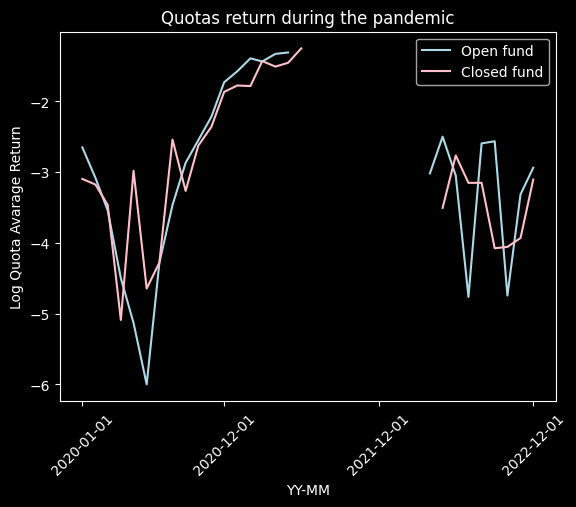

In [62]:
# Plot graph for quotas return during the pandemic
plt.plot(pandemic_return.loc[pandemic_return['CONDOM_Aberto']==1, 'year_month'],
         pandemic_return.loc[pandemic_return['CONDOM_Aberto']==1, 'log_return'], color ='lightblue', label='Open fund')

plt.plot(pandemic_return.loc[pandemic_return['CONDOM_Aberto']==0, 'year_month'],
         pandemic_return.loc[pandemic_return['CONDOM_Aberto']==0, 'log_return'], color ='pink', label='Closed fund')

# add title and labels
plt.title('Quotas return during the pandemic')
plt.xlabel('YY-MM')
plt.ylabel('Log Quota Avarage Return')

plt.legend()

plt.xticks(ticks=['2020-01','2020-12','2021-12','2022-12'],  rotation=45)

So, even though more funds were created during the pandemic, seems like the returns were even positive. Funds open to retail investors (open funds) suffered with extreme negatuive returns while exclusive funds (closed funds) profit duruing the early stages of the pandemic.

## Returns: historical analysis

In [23]:
# Print basic statistics
# Mean
round(fund_df[['VL_QUOTA','VL_PATRIM_LIQ', 'NR_COTST', 'quota_return']].mean(),2)

VL_QUOTA         1.252722e+05
VL_PATRIM_LIQ    4.444398e+08
NR_COTST         1.089180e+03
quota_return     4.277872e+05
dtype: float64

In [19]:
# Mean by year_month
round(fund_df.groupby(fund_df['year_month'].dt.year)[['VL_QUOTA','VL_PATRIM_LIQ', 'NR_COTST', 'quota_return']].mean(),2)

,VL_QUOTA,VL_PATRIM_LIQ,NR_COTST,quota_return
year_month,,,,
2020,470602.20,4.679023e+08,1196.73,459244.49
2021,16257.09,4.554849e+08,1107.67,929.79
2022,53662.03,4.321925e+08,1101.58,38859.88
2023,133844.17,4.268117e+08,1030.85,1424037.26
2024,15237.90,4.511178e+08,1032.11,2216.67


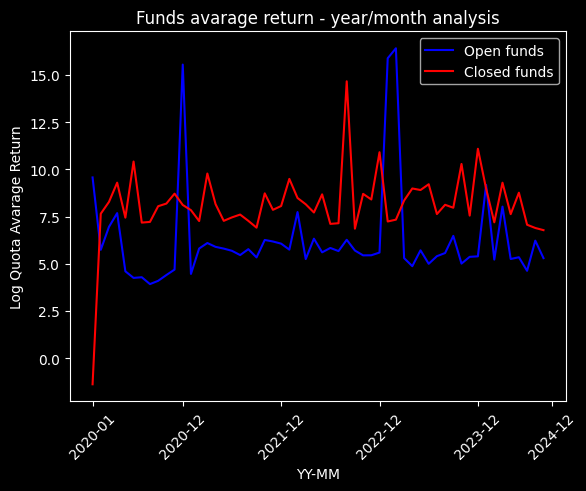

In [25]:
# Funds avarage return considering if they are opened/closed
avarage_return = fund_df.groupby(['year_month', 'CONDOM_Aberto'])['quota_return'].mean().reset_index()
avarage_return['LN_quota_return']  = np.log(avarage_return['quota_return'])

# Plot graph
## open funds
plt.plot(avarage_return.loc[avarage_return['CONDOM_Aberto'] == 1, 'year_month'],
         avarage_return.loc[avarage_return['CONDOM_Aberto'] == 1, 'LN_quota_return'], label = 'Open funds', color='blue')
# closed funds
plt.plot(avarage_return.loc[avarage_return['CONDOM_Aberto'] == 0, 'year_month'],
         avarage_return.loc[avarage_return['CONDOM_Aberto'] == 0, 'LN_quota_return'], label = 'Closed funds', color='red')

# add title and labels
plt.title('Funds avarage return - year/month analysis')
plt.xlabel('YY-MM')
plt.ylabel('Log Quota Avarage Return')


plt.xticks(ticks=['2020-01','2020-12','2021-12','2022-12','2023-12','2024-12'],  rotation=45)

# add funds type
plt.legend()


We see here that open funds have a lower return compared to closed funds. Which is expected, agents with private information or access to better assets won't share it with retail investors. So now we know there's something different between funds, let's explore the main features of open and closed funds.

## Funds main features

In [87]:
# Create a df for each type of fund
closed_funds = fund_df[fund_df['CONDOM_Aberto']==0]
opened_funds = fund_df[fund_df['CONDOM_Aberto']==1]

# # Recent years
# closed_funds = closed_funds[closed_funds['year_month'] >= '2023-01']
# opened_funds = opened_funds[opened_funds['year_month'] >= '2023-01']


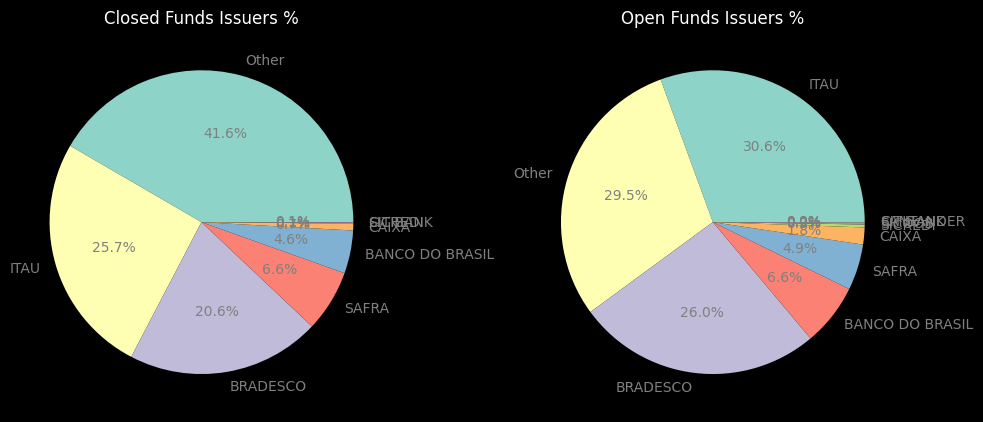

In [88]:
# Check who are the main issuers
closed_count_issuer = closed_funds['issuer_name'].value_counts()/len(closed_funds['issuer_name'])*100
closed_count_issuer.sort_values()

open_count_issuer = opened_funds['issuer_name'].value_counts()/len(opened_funds['issuer_name'])*100
open_count_issuer.sort_values()

# Plot puie graph
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pie(closed_count_issuer, labels=closed_count_issuer.index,
        autopct='%1.1f%%',textprops={'color':'grey'})
# Title
plt.title('Closed Funds Issuers %')

plt.subplot(1,2,2)
plt.pie(open_count_issuer, labels=open_count_issuer.index,
        autopct='%1.1f%%',textprops={'color':'grey'})
# Title
plt.title('Open Funds Issuers %')

# distribute both graphs
plt.tight_layout()



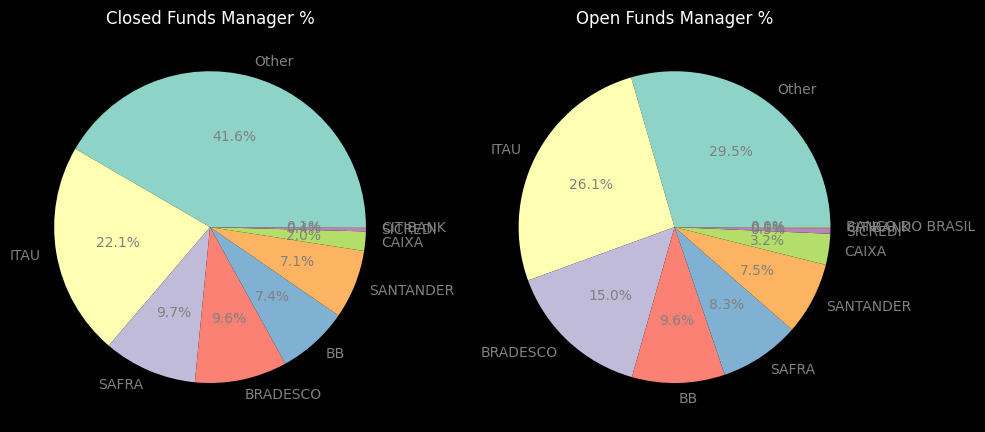

In [89]:
# Check who are the main issuers
closed_count_manager = closed_funds['manager_name'].value_counts()/len(closed_funds['manager_name'])*100
closed_count_manager.sort_values()

open_count_manager = opened_funds['manager_name'].value_counts()/len(opened_funds['manager_name'])*100
open_count_manager.sort_values()

# Plot puie graph
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pie(closed_count_manager, labels=closed_count_manager.index,
        autopct='%1.1f%%',textprops={'color':'grey'})
# Title
plt.title('Closed Funds Manager %')

plt.subplot(1,2,2)
plt.pie(open_count_manager, labels=open_count_manager.index,
        autopct='%1.1f%%',textprops={'color':'grey'})
# Title
plt.title('Open Funds Manager %')

# distribute both graphs
plt.tight_layout()


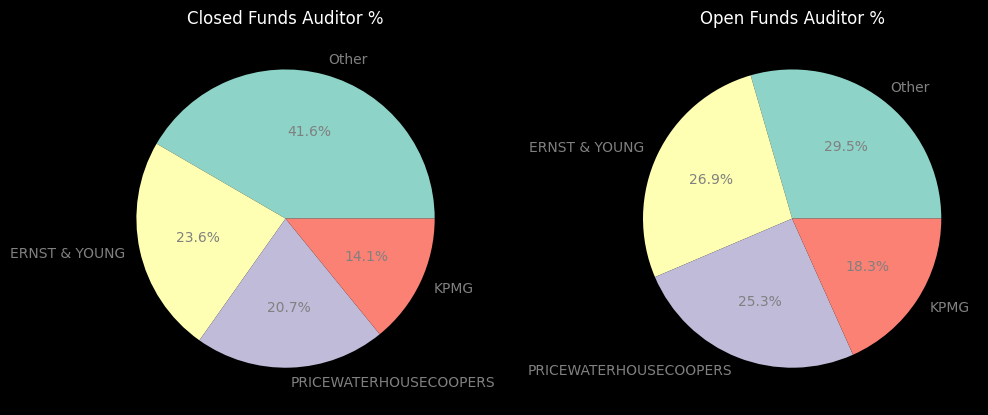

In [90]:
# Check who are the main issuers
closed_count_b4 = closed_funds['big4_name'].value_counts()/len(closed_funds['big4_name'])*100
closed_count_b4.sort_values()

open_count_b4 = opened_funds['big4_name'].value_counts()/len(opened_funds['big4_name'])*100
open_count_b4.sort_values()

# Plot puie graph
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.pie(closed_count_b4, labels=closed_count_b4.index,
        autopct='%1.1f%%',textprops={'color':'grey'})
# Title
plt.title('Closed Funds Auditor %')

plt.subplot(1,2,2)
plt.pie(open_count_b4, labels=open_count_b4.index,
        autopct='%1.1f%%',textprops={'color':'grey'})
# Title
plt.title('Open Funds Auditor %')

# distribute both graphs
plt.tight_layout()